In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
store = pd.read_csv('data/store.csv')

In [3]:
store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [4]:
train = pd.read_csv('data/train.csv', low_memory=False)

In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test = pd.read_csv('data/test.csv')

In [7]:
test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [8]:
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [9]:
print(f'Earliest train date: {min(train.Date)}')
print(f'Latest train date: {max(train.Date)}')
print(f'Earliest test date: {min(test.Date)}')
print(f'Latest test date: {max(test.Date)}')

Earliest train date: 2013-01-01 00:00:00
Latest train date: 2015-07-31 00:00:00
Earliest test date: 2015-08-01 00:00:00
Latest test date: 2015-09-17 00:00:00


# Эксперимент 1: Линейная регрессия

In [10]:
merged_train = train.merge(store, how='left', on='Store')
merged_test = test.merge(store, how='left', on='Store')

In [11]:
merged_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [13]:
merged_train.CompetitionDistance.isna().sum()

2642

In [14]:
merged_train.Open.isna().sum()

0

In [23]:
merged_train[x_cols + ['Customers', 'Open', 'CompetitionDistance']].head(2)

,Store,DayOfWeek,Promo,SchoolHoliday,Promo2,Customers,Open,CompetitionDistance
0,1,5,1,1,0,555,1,1270.0
1,2,5,1,1,1,625,1,570.0


In [24]:
X_train = merged_train[x_cols]
y_train = merged_train['Sales']
X_test = merged_test[x_cols]

In [25]:
X_train.head(2)

,Store,DayOfWeek,Promo,SchoolHoliday,Promo2
0,1,5,1,1,0
1,2,5,1,1,1


<AxesSubplot:>

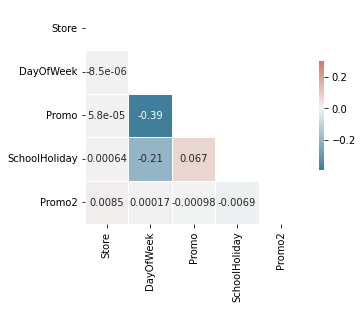

In [26]:
corr_table = X_train.corr()
mask = np.triu(np.ones_like(corr_table, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test = lr.predict(X_test)

In [33]:
import statsmodels.api as sm

#fit simple linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.690
Method:                 Least Squares   F-statistic:                          4.529e+05
Date:                Fri, 11 Mar 2022   Prob (F-statistic):                        0.00
Time:                        18:52:36   Log-Likelihood:                     -9.8448e+06
No. Observations:             1017209   AIC:                                  1.969e+07
Df Residuals:                 1017204   BIC:                                  1.969e+07
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [34]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrsimple.csv', index=False)

# Эксперимент №2: Линейная регрессия с дополнительными параметрами.

In [35]:
merged_train.Open.value_counts().reset_index()

,index,Open
0,1,844392
1,0,172817


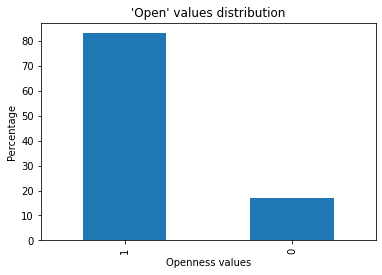

In [40]:
ax = merged_train.Open.value_counts().apply(lambda x: x/len(merged_train)*100).plot.bar(title="'Open' values distribution")
ax.set_ylabel('Percentage')
ax.set_xlabel("Openness values")
plt.show()

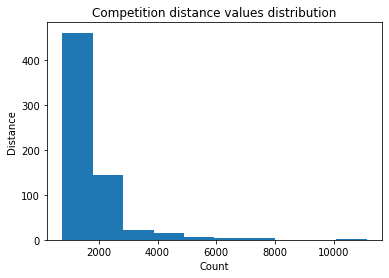

In [42]:
ax = merged_train.CompetitionDistance.value_counts().plot.hist(title="Competition distance values distribution")
ax.set_ylabel('Distance')
ax.set_xlabel("Count")
plt.show()

In [43]:
merged_train.Open.fillna(0, inplace=True)
merged_test.Open.fillna(0, inplace=True)

In [44]:
merged_train.CompetitionDistance.fillna(merged_train['CompetitionDistance'].median(), inplace=True)
merged_test.CompetitionDistance.fillna(merged_test['CompetitionDistance'].median(), inplace=True)

In [45]:
x_cols = ['Store', 'Open', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2']

In [46]:
X_train = merged_train[x_cols]
y_train = merged_train['Sales']
X_test = merged_test[x_cols]

In [47]:
X_train.isna().sum()

Store                  0
Open                   0
DayOfWeek              0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
Promo2                 0
dtype: int64

<AxesSubplot:>

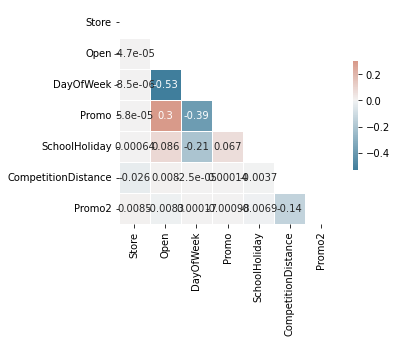

In [48]:
corr_table = X_train.corr()
mask = np.triu(np.ones_like(corr_table, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test = lr.predict(X_test)

In [50]:
#fit simple linear regression model
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                 1.712e+05
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        18:54:06   Log-Likelihood:            -9.4453e+06
No. Observations:             1017209   AIC:                         1.889e+07
Df Residuals:                 1017201   BIC:                         1.889e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 967.2707    

In [51]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrsimplewithoutnans.csv', index=False)

In [52]:
lr.coef_

array([ 5.92519957e-02,  5.84910150e+03, -1.08686211e+02,  2.07147135e+03,
        6.00669876e+01, -1.79773434e-02, -7.01023483e+02])

In [55]:
train[train['Open'] == np.nan].Sales.value_counts()

Series([], Name: Sales, dtype: int64)

In [53]:
mrg.Open.isna().sum()

NameError: name 'mrg' is not defined

# Эксперимент №3: выбросить признаки с малым весом

In [56]:
x_cols.remove('Store')
x_cols.remove('CompetitionDistance')

In [57]:
x_cols

['Open', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'Promo2']

In [58]:
X_train = merged_train[x_cols]
y_train = merged_train['Sales']
X_test = merged_test[x_cols]

<AxesSubplot:>

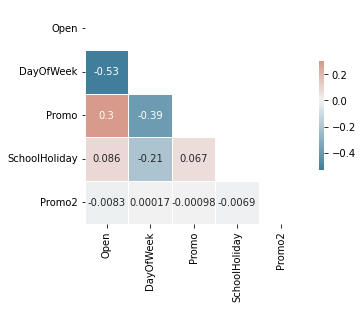

In [59]:
corr_table = X_train.corr()
mask = np.triu(np.ones_like(corr_table, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test = lr.predict(X_test)

In [61]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrsimplewithoughtlowweights.csv', index=False)

In [62]:
X_train.head()

,Open,DayOfWeek,Promo,SchoolHoliday,Promo2
0,1,5,1,1,0
1,1,5,1,1,1
2,1,5,1,1,1
3,1,5,1,1,0
4,1,5,1,1,0


In [63]:
# Эксперимент 4 - заскейлить фичи

In [64]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [65]:
lr = LinearRegression()
lr.fit(X_train_norm, y_train)
y_test = lr.predict(X_test_norm)

In [66]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrsimplescale.csv', index=False)

# Эксперимент 5: normalize без Open

In [67]:
X_train = X_train.drop(columns="Open")
X_test = X_test.drop(columns="Open")

In [68]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [69]:
lr = LinearRegression()
lr.fit(X_train_norm, y_train)
y_test = lr.predict(X_test_norm)

In [70]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrsimplescale2.csv', index=False)

In [71]:
X_train

,DayOfWeek,Promo,SchoolHoliday,Promo2
0,5,1,1,0
1,5,1,1,1
2,5,1,1,1
3,5,1,1,0
4,5,1,1,0
...,...,...,...,...
1017204,2,0,1,1
1017205,2,0,1,0
1017206,2,0,1,0
1017207,2,0,1,0


# Эксперимент №6: cat features

In [72]:
merged_train.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [73]:
merged_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [74]:
cat_cols = ['StateHoliday', 'StoreType', 'Assortment']

In [77]:
encoder = OneHotEncoder(drop='first', sparse=False).fit(merged_train[cat_cols])
encoded_cols = list(encoder.get_feature_names(cat_cols))

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
from sklearn.preprocessing import OneHotEncoder

In [79]:
encoded_cat_train = pd.get_dummies(merged_train[cat_cols], drop_first=True)
encoded_cat_test = pd.get_dummies(merged_test[cat_cols], drop_first=True)

In [80]:
dummy_df = pd.DataFrame(pd.DataFrame(0, index=np.arange(len(test)), columns=['StateHoliday_b', 'StateHoliday_c']))
X_train = pd.concat([X_train, encoded_cat_train], axis=1, join='inner')
X_test = pd.concat([X_test, encoded_cat_test], axis=1, join='inner')
X_test = pd.concat([X_test, dummy_df], axis=1, join='inner')
X_test = X_test.reindex(columns=X_train.columns)

In [81]:
X_train.head(2)

,DayOfWeek,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,5,1,1,0,0,0,0,0,1,0,0,0
1,5,1,1,1,0,0,0,0,0,0,0,0


In [82]:
X_test.head(2)

,DayOfWeek,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,4,1,0,0,0,0,0,0,1,0,0,0
1,4,1,0,1,0,0,0,0,0,0,0,0


In [83]:
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [84]:
lr = LinearRegression()
lr.fit(X_train_norm, y_train)
y_test = lr.predict(X_test_norm)

In [85]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_lrwithcats.csv', index=False)

# Эксперимент №7

In [86]:
from xgboost import XGBRegressor

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [87]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, booster='gbtree'
                    )
xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
y_test = xgb.predict(X_test)

In [89]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb.csv', index=False)

# Эксперимент №8

In [100]:
X_train['Open'] = merged_train.Open
X_test['Open'] = merged_test.Open

In [101]:
X_test

,DayOfWeek,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,Open
0,4,1,0,0,0,0,0,0,1,0,0,0,1.0
1,4,1,0,1,0,0,0,0,0,0,0,0,1.0
2,4,1,0,0,0,0,0,0,0,0,0,1,1.0
3,4,1,0,0,0,0,0,0,0,0,0,0,1.0
4,4,1,0,0,0,0,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,6,0,0,1,0,0,0,0,0,0,0,0,1.0
41084,6,0,0,0,0,0,0,0,1,0,0,1,1.0
41085,6,0,0,0,0,0,0,0,0,0,0,1,1.0
41086,6,0,0,0,0,0,0,0,0,0,0,1,1.0


In [92]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, booster='gbtree'
                    )
xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
y_test = xgb.predict(X_test)

In [94]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb_with_open.csv', index=False)

# Эксперимент №9

In [95]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, booster='gblinear'
                    )
xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [96]:
y_test = xgb.predict(X_test)

In [97]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb_gblinear.csv', index=False)

# Эксперимент №10

In [98]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.9, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, booster='gbtree'
                    )
xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.9, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
y_test = xgb.predict(X_test)

In [102]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb_lr_09.csv', index=False)

# Experiment №10 - boolean day of week 


In [103]:
X_train_weekend = X_train
X_test_weekend = X_test

In [104]:
X_train_weekend.DayOfWeek = X_train_weekend.DayOfWeek.apply(lambda x: 0 if x <= 5 else 1) 
X_test_weekend.DayOfWeek = X_test_weekend.DayOfWeek.apply(lambda x: 0 if x <= 5 else 1)

In [105]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.9, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, booster='gbtree'
                    )
xgb.fit(X_train_weekend, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.9, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
y_test = xgb.predict(X_test_weekend)

In [107]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb_lr_09_boolean_dayofweek.csv', index=False)

# Experiment №11 - Month Features

In [108]:
def split_date(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.week
    
split_date(merged_train)
split_date(merged_test)

merged_train.head(2)

/var/folders/9y/_v4x2t1n3pl53wzm73n7w7w40000gn/T/ipykernel_24164/1192351951.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df.Date.dt.week
/var/folders/9y/_v4x2t1n3pl53wzm73n7w7w40000gn/T/ipykernel_24164/1192351951.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df.Date.dt.week


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31


In [109]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
comp_months(merged_train)
comp_months(merged_test)

In [110]:
merged_train.head(2).columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen'],
      dtype='object')

In [111]:
X_train_ext = pd.concat([X_train, merged_train[['Day', 'Month', 'WeekOfYear', 'Year', 'CompetitionOpen']]], axis=1, join='inner')

X_test_ext = pd.concat([X_test, merged_test[['Day', 'Month', 'WeekOfYear', 'Year', 'CompetitionOpen']]], axis=1, join='inner')

In [112]:
X_test_ext.DayOfWeek = test.DayOfWeek

X_train_ext.DayOfWeek = train.DayOfWeek

In [113]:
xgb = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.9, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7, booster='gbtree'
                    )
xgb.fit(X_train_ext, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.9, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
y_test = xgb.predict(X_test_ext)

In [115]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Sales'] = y_test
submission.to_csv('submission_xgb_ext.csv', index=False)